# Poisson experiments

This notebook contains a collection of Poisson experiments, including the following:
- Poisson distribution
- Poisson process
- Poisson regression
- Implementation of the Poisson regression model

Author: https://www.github.com/deburky

## Poisson process

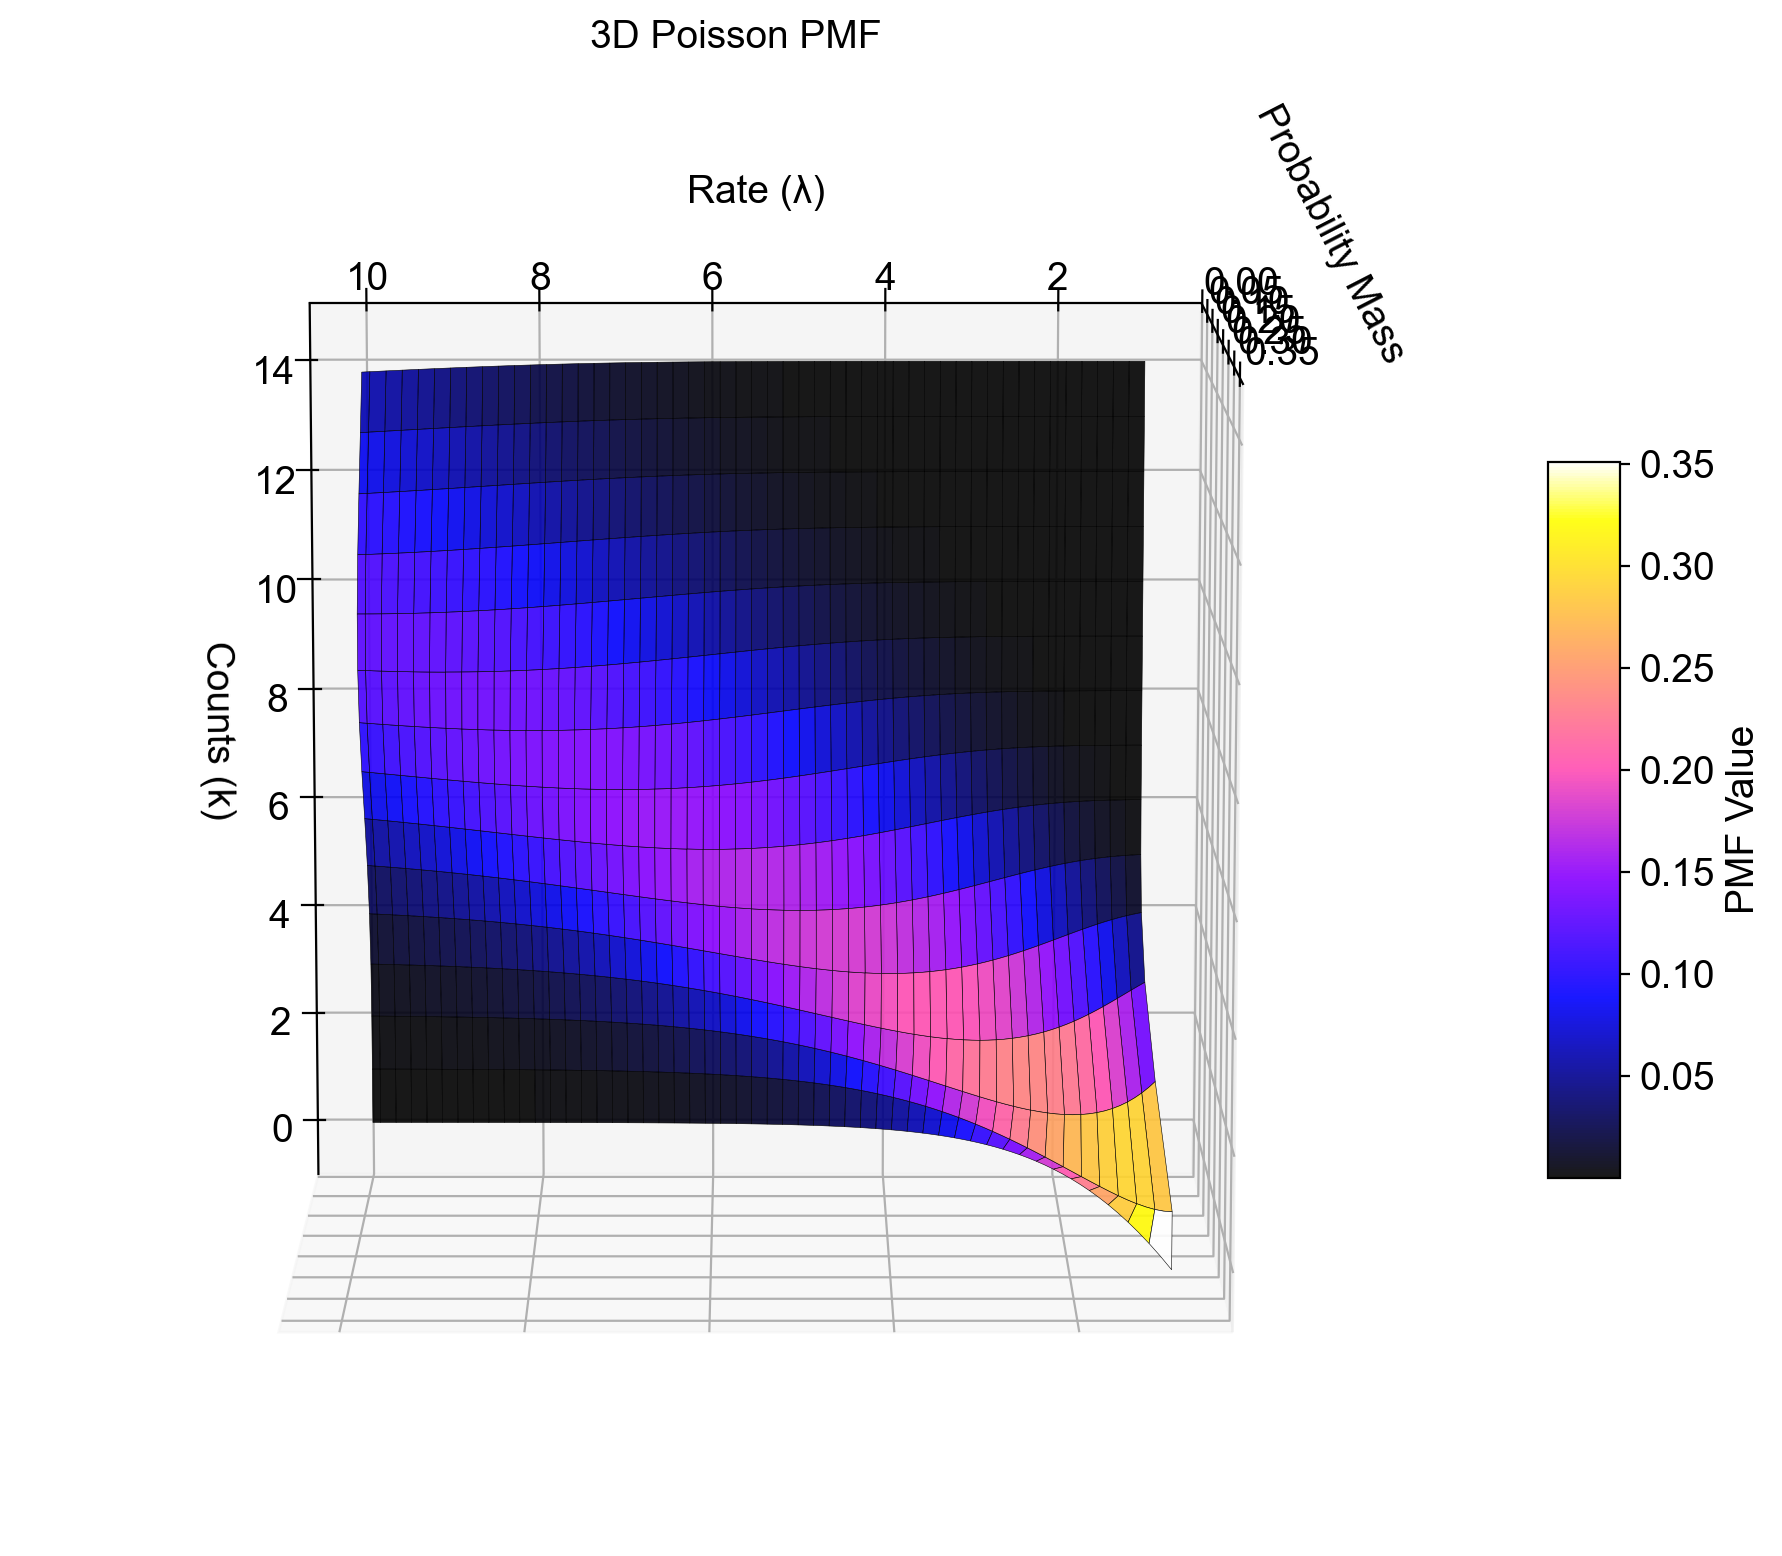

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import poisson

# Define the range for k (counts) and lambda (rate parameter)
k_values = np.arange(0, 15, 1)
lambda_values = np.linspace(1, 10, 100)

# Create a meshgrid for k and lambda
k_mesh, lambda_mesh = np.meshgrid(k_values, lambda_values)

# Compute the Poisson PMF
poisson_pmf = poisson.pmf(k_mesh, lambda_mesh)

# Plot the 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot surface with gnuplot2-like style
surf = ax.plot_surface(
    k_mesh,
    lambda_mesh,
    poisson_pmf,
    cmap="gnuplot2",
    edgecolor="k",
    linewidth=0.2,
    alpha=0.9,
)

# Add labels and title
ax.set_title("3D Poisson PMF", fontsize=14, pad=20)
ax.set_xlabel("Counts (k)", labelpad=10)
ax.set_ylabel("Rate (λ)", labelpad=10)
ax.set_zlabel("Probability Mass", labelpad=10)

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=10, label="PMF Value")

# Adjust viewing angle for better aesthetics
ax.view_init(elev=100, azim=180)

# Show the plot
plt.tight_layout()
plt.show()

Poisson series example from R. Fisher (1925, 14th edition, p. 55), select 200 observations from Bortkewitch's data (Prussian Horse Kick Data).

Data Sources:

- [McElreath 2020. Statistical Rethinking, 2nd edition, CRC Press](https://github.com/rmcelreath/rethinking)
- [VonBort](https://rdrr.io/cran/vcd/man/VonBort.html)

|  Count  |  Frequency Observed  |  Frequency Predicted  |
|:-------:|:--------------------:|:---------------------:|
|  0.00   |        109.00        |        108.67         |
|  1.00   |        65.00         |         66.29         |
|  2.00   |        22.00         |         20.22         |
|  3.00   |         3.00         |         4.11          |
|  4.00   |         1.00         |         0.63          |
|  5.00   |         0.00         |         0.08          |
|  6.00   |         0.00         |         0.01          |


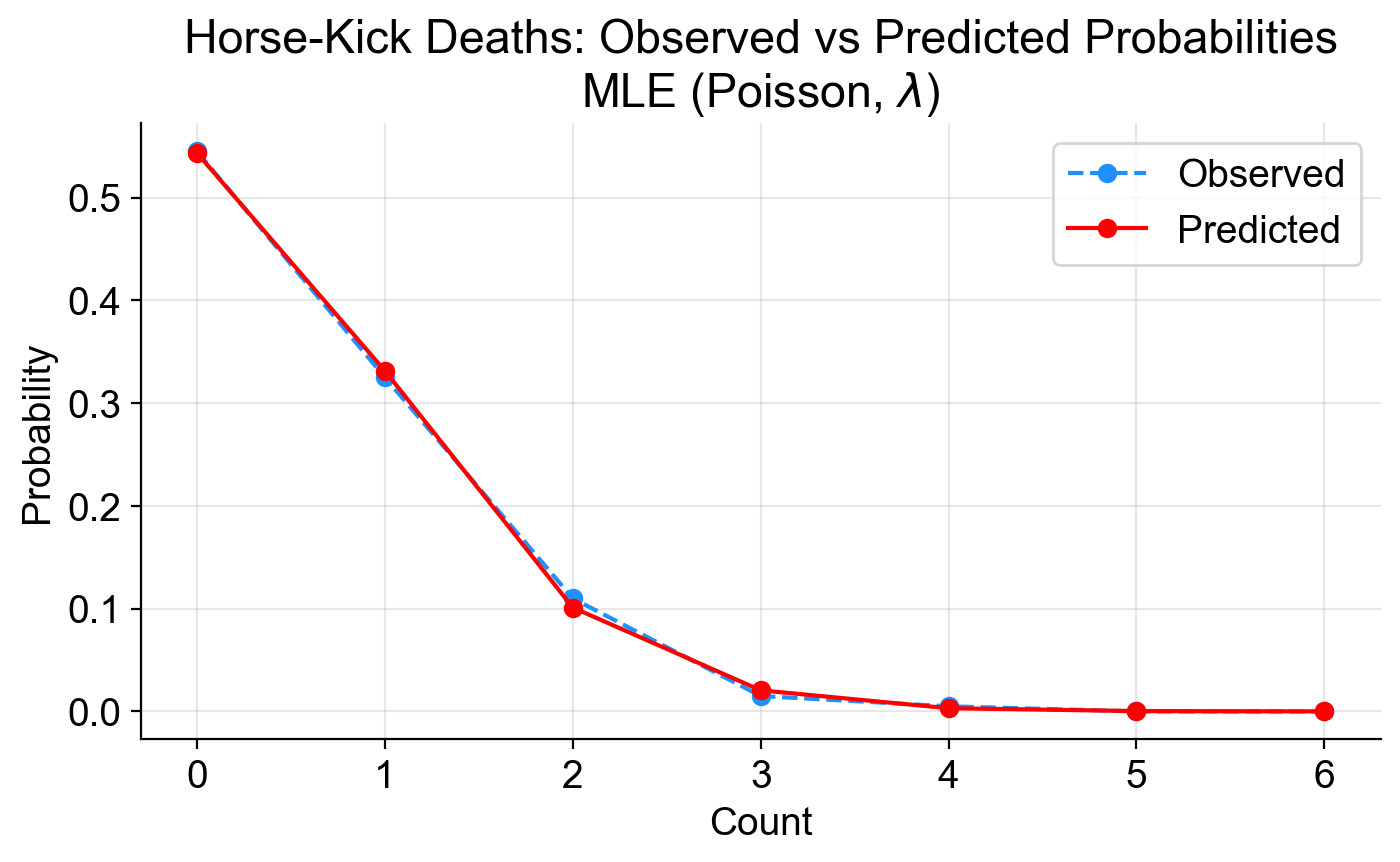

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from utils import plot_observed_vs_predicted

pd.set_option("display.float_format", "{:.2f}".format)

plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["font.size"] = 14

# path_to_csv = (
#     "https://raw.githubusercontent.com/"
#     "vincentarelbundock/Rdatasets/refs/"
#     "heads/master/csv/vcd/VonBort.csv"
# )

path_to_csv = "datasets/PRUS/VonBort.csv"
horse_data = pd.read_csv(path_to_csv, usecols=["year", "corps", "deaths", "fisher"])
horse_data = horse_data.query("fisher == 'yes'")

fig = plt.figure(figsize=(8, 4))

y = horse_data["deaths"]

mle = np.full(len(y), y.mean())

# Plot Observed vs Predicted probabilities
df_results = plot_observed_vs_predicted(
    y,
    mle,
    max_count=6,
    title="Horse-Kick Deaths: Observed vs Predicted Probabilities",
    model_name="MLE (Poisson, $\\lambda$)",
)

# Table 4 from Fisher (1925)
subset_df_results = df_results.query("Count <= 6")[
    ["Count", "Frequency Observed", "Frequency Predicted"]
]

# Display the table
out = subset_df_results.to_markdown(
    index=False,
    tablefmt="pipe",
    colalign=["center"] * len(subset_df_results.columns),
    floatfmt=".2f",
)
print(out)

## Poisson Regression

**Dataset**: rwm ("COUNT" R Package)

This dataset uses the German health registry for the years 1984–1988, providing health information for years prior to the health reform.

- **Type**: Health dataset
- **Total Observations**: 27,326
- **Key Features**:
  - **docvis**: Number of visits to the doctor during the year (0–121)
  - **age**: Age range of individuals (25–64)
  - **educ**: Years of formal education (7–18)
  - **hhninc**: Household yearly income in DM/1000

---

**Subset**: rwm1984 ("COUNT" R Package)

This subset focuses on the German health registry for the year 1984. It contains 3,874 observations with the following variables:

- **docvis**: Number of visits to the doctor during the year (0–121)
1. **hospvis**: Number of days in the hospital during the year (0–51)
2. **edlevel**: Educational level (categorical: 1–4)
3. **age**: Age range of individuals (25–64)
4. **outwork**: Indicator for being out of work (1 = out of work, 0 = working)
5. **female**: Indicator for gender (1 = female, 0 = male)
6. **married**: Indicator for marital status (1 = married, 0 = not married)
7. **kids**: Indicator for having children (1 = yes, 0 = no)
8. **hhninc**: Household yearly income in DM/1000
9. **educ**: Years of formal education (7–18)
10. **self**: Indicator for self-employment (1 = self-employed, 0 = not self-employed)
- **edlevel1**: Not a high school graduate (1/0)
- **edlevel2**: High school graduate (1/0)
- **edlevel3**: University/college graduate (1/0)
- **edlevel4**: Graduate school (1/0)

---

Hilbe, Joseph, M (2014), Modeling Count Data, Cambridge University Press Hilbe, Joseph M
(2011), Negative Binomial Regression, Cambridge University Press Hilbe, J. and W. Greene (2008).
Count Response Regression Models, in ed. C.R. Rao, J.P Miller, and D.C. Rao, Epidemiology and
Medical Statistics, Elsevier Handbook of Statistics Series. London, UK: Elsevier.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln
from matplotlib.ticker import MaxNLocator


def plot_observed_vs_predicted(
    y,
    mu,
    max_count=15,
    alpha=None,
    title="Observed vs Predicted Probabilities",
    model_name="Model",
    ax=None,
):
    """
    Plot observed vs predicted probabilities for count data.

    Parameters:
    - y (array-like): Observed count data.
    - mu (array-like): Predicted mean values from the model.
    - max_count (int): Maximum count to consider for probabilities.
    - alpha (float, optional): Overdispersion parameter for Negative Binomial.
      If None, assumes Poisson (alpha=0).
    - title (str): Title for the plot.
    - model_name (str): Name of the model for labeling.
    - ax (matplotlib.axes._subplots.AxesSubplot, optional): Matplotlib axis to plot on.

    Returns:
    - None. Plots the chart on the provided axis or creates a new one.
    """
    counts = np.arange(0, max_count + 1)
    predicted_probs = []
    observed_probs = []

    for count in counts:
        if alpha is None or alpha == 0:  # Poisson case
            pred_prob = np.mean(np.exp(-mu) * (mu**count) / np.exp(gammaln(count + 1)))
        else:  # Negative Binomial case
            amu = mu * alpha
            pred_prob = np.mean(
                np.exp(
                    count * np.log(amu / (1 + amu))
                    - (1 / alpha) * np.log(1 + amu)
                    + gammaln(count + 1 / alpha)
                    - gammaln(count + 1)
                    - gammaln(1 / alpha)
                )
            )
        predicted_probs.append(pred_prob)
        observed_probs.append(np.mean(y == count))

    # Create a DataFrame for plotting
    results_df = pd.DataFrame(
        {"Count": counts, "Observed": observed_probs, "Predicted": predicted_probs}
    )

    # Use the provided axis or create a new one
    if ax is None:
        ax = plt.gca()

    # Plot observed vs predicted probabilities
    ax.plot(
        results_df["Count"],
        results_df["Observed"],
        label="Observed",
        marker="o",
        linestyle="--",
        color="dodgerblue",
    )
    ax.plot(
        results_df["Count"],
        results_df["Predicted"],
        label="Predicted",
        marker="o",
        linestyle="-",
        color="red",
    )
    ax.set_title(f"{title}\n{model_name}")
    ax.set_xlabel("Count")
    ax.set_ylabel("Probability")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend()
    ax.grid(True, alpha=0.3)

### Model from Modeling Count Data by Joseph M. Hilbe

For example, given a random sample of 1000 patient observations from the German Health Survey for the year 1984, the following Poisson model output explains the years expected number of doctor visits on the basis of gender and marital status, both recorded as binary (1/0) variables, and the continuous predictor, age.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3874
Model:                            GLM   Df Residuals:                     3871
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8334.4
Date:                Thu, 01 May 2025   Deviance:                       4264.6
Time:                        14:56:21   Pearson chi2:                 6.46e+03
No. Iterations:                     8   Pseudo R-squ. (CS):            0.05832
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
female_1       0.4110      0.049      8.413      0.0

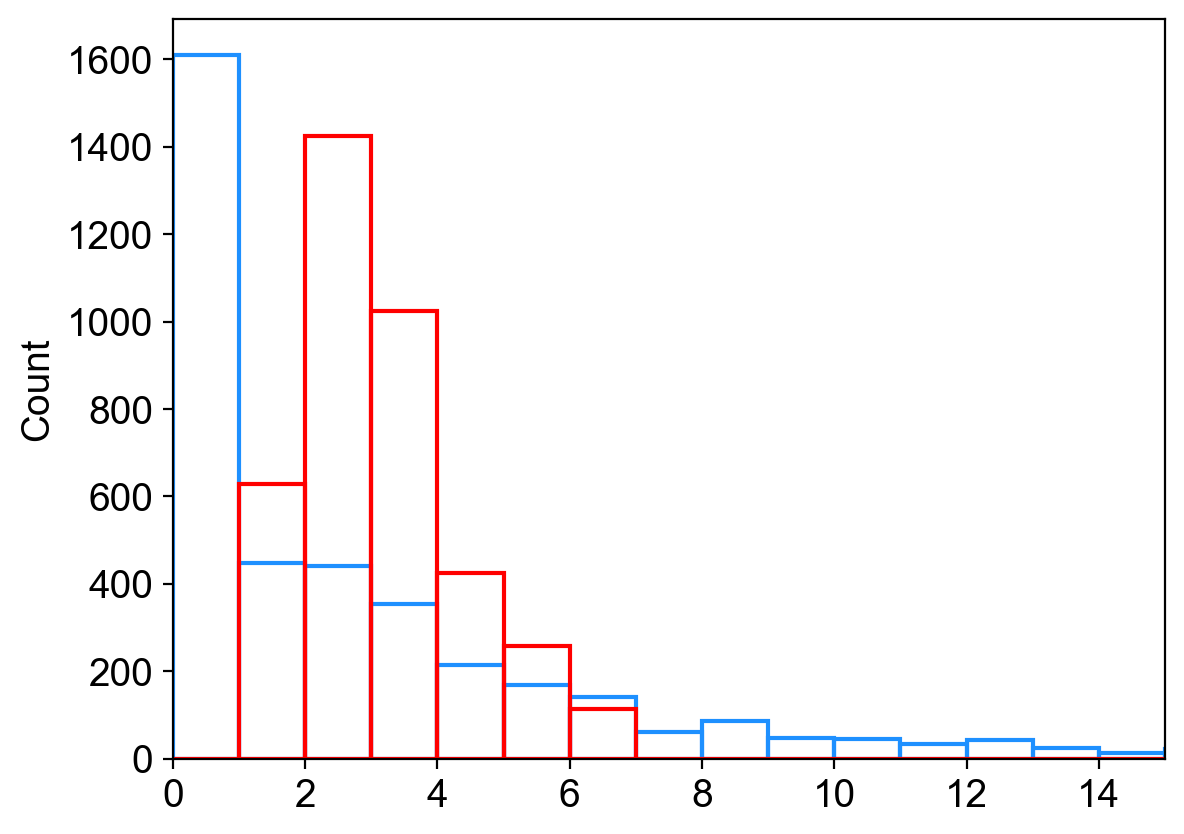

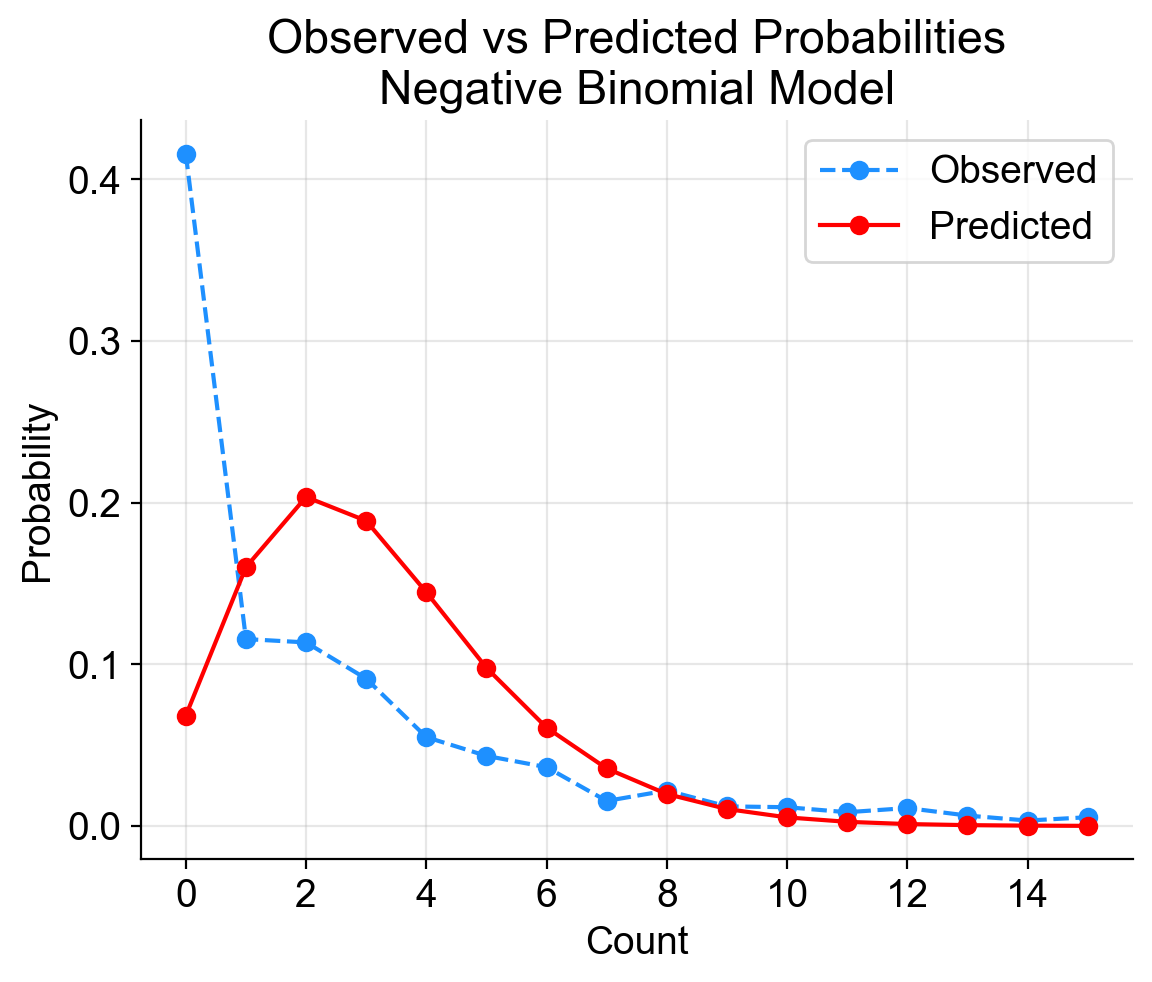

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import poisson, chi2

%config InlineBackend.figure_format = 'retina'

# Load the dataset
dataset = pd.read_csv("datasets/COUNT/rwm1984.csv")

cat_columns = ["female", "married"]
num_columns = ["age"]

cat_frame = pd.get_dummies(
    dataset[cat_columns].astype("category"), drop_first=True, dtype=int
)
num_frame = dataset[num_columns]

X = pd.concat([cat_frame, num_frame], axis=1)
y = dataset["docvis"].values

# Fit a Poisson regression model
poisson_model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=2.0)).fit()

# Display the summary
print(poisson_model.summary())

# Calculate the Poisson probabilities
mu = poisson_model.predict(X)
poisson_probs = poisson.pmf(y, mu)

# Compute the log-likelihood
log_likelihood = np.sum(np.log(poisson_probs))
print(f"Log-likelihood of the data: {log_likelihood}")

# Select a common range for bins
bins_min = min(y.min(), mu.min())
bins_max = max(y.max(), mu.max())

# Create bins for the histogram
bins = np.arange(bins_min, bins_max + 1)

# Plot predicted vs. observed values in a histogram using PMF
sns.histplot(
    y, color="dodgerblue", label="Observed", fill=False, bins=bins, linewidth=1.5
)
sns.histplot(mu, color="red", label="Predicted", fill=False, bins=bins, linewidth=1.5)

plt.xlim(0, 15)

# Use log likelihood of the null model
null_model = poisson(y.mean())
null_log_likelihood = np.sum(np.log(null_model.pmf(y)))

# Perform Chi-Square Test on the log-likelihood
chi2_stat = -2 * (null_log_likelihood - log_likelihood)
p_value = 1 - chi2.cdf(chi2_stat, 1)

print(f"Chi-Square Statistic: {chi2_stat}, p-value: {p_value}")

fig, ax = plt.subplots()
plot_observed_vs_predicted(
    y,
    mu,
    max_count=15,
    alpha=0.0,
    title="Observed vs Predicted Probabilities",
    model_name="Negative Binomial Model",
    ax=ax,
)

When exponentiated, Poisson and NB2 parameter estimates may be interpreted as incidence rate ratios.

The estimates may be interpreted as:
- Females are expected to visit the doctor some 50% more times during the year than males, holding marital status and age constant.
- Married patients are expected to visit the doctor some 16% fewer times during the year than unmarried patients, holding gender and age constant.
- For a one year increase in age, the rate of visits to the doctor increases by some 2%, with marital status and gender held constant.

In [26]:
# Exponentiate the coefficients
poisson_model_odds = np.exp(poisson_model.params)

# Display the exponentiated coefficients
print(poisson_model_odds)

female_1    1.51
married_1   0.82
age         1.02
dtype: float64


### Poisson model

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3874
Model:                            GLM   Df Residuals:                     3866
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15503.
Date:                Thu, 01 May 2025   Deviance:                       23923.
Time:                        14:56:26   Pearson chi2:                 4.34e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3826
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0156      0.045      0.348      0.7

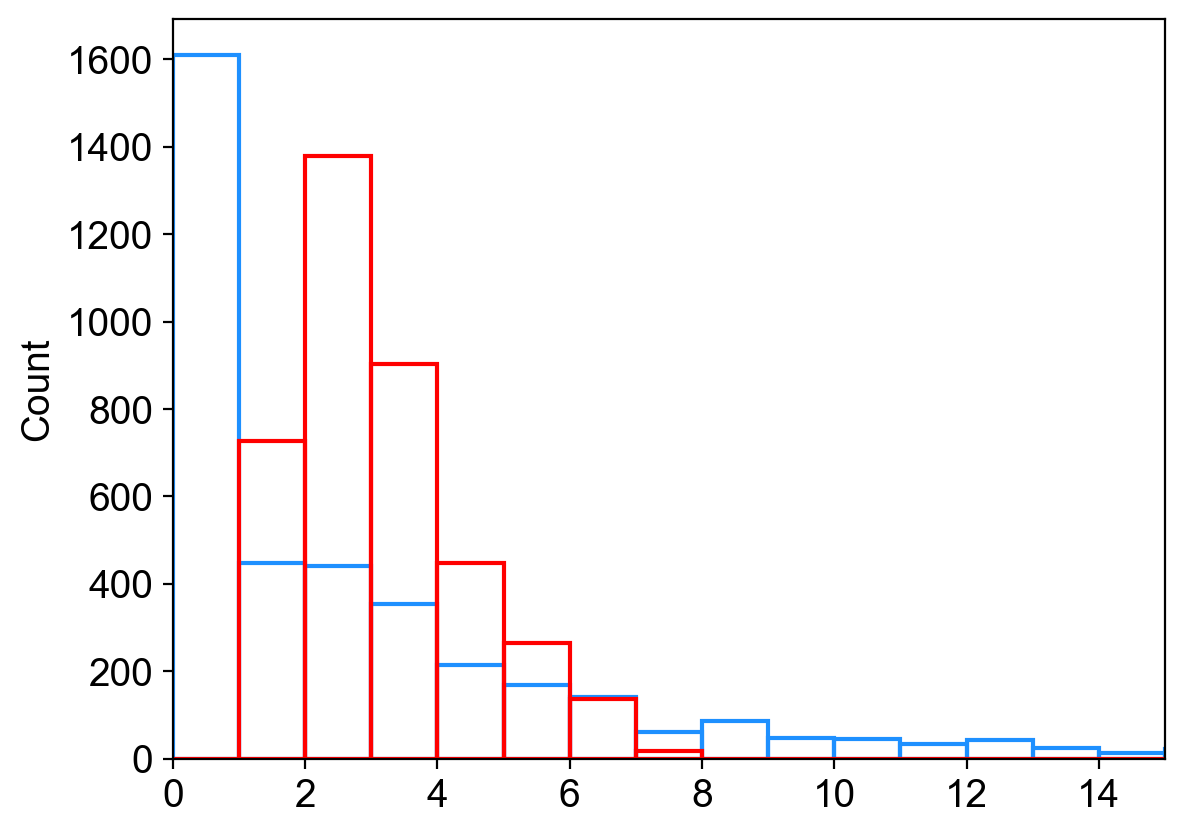

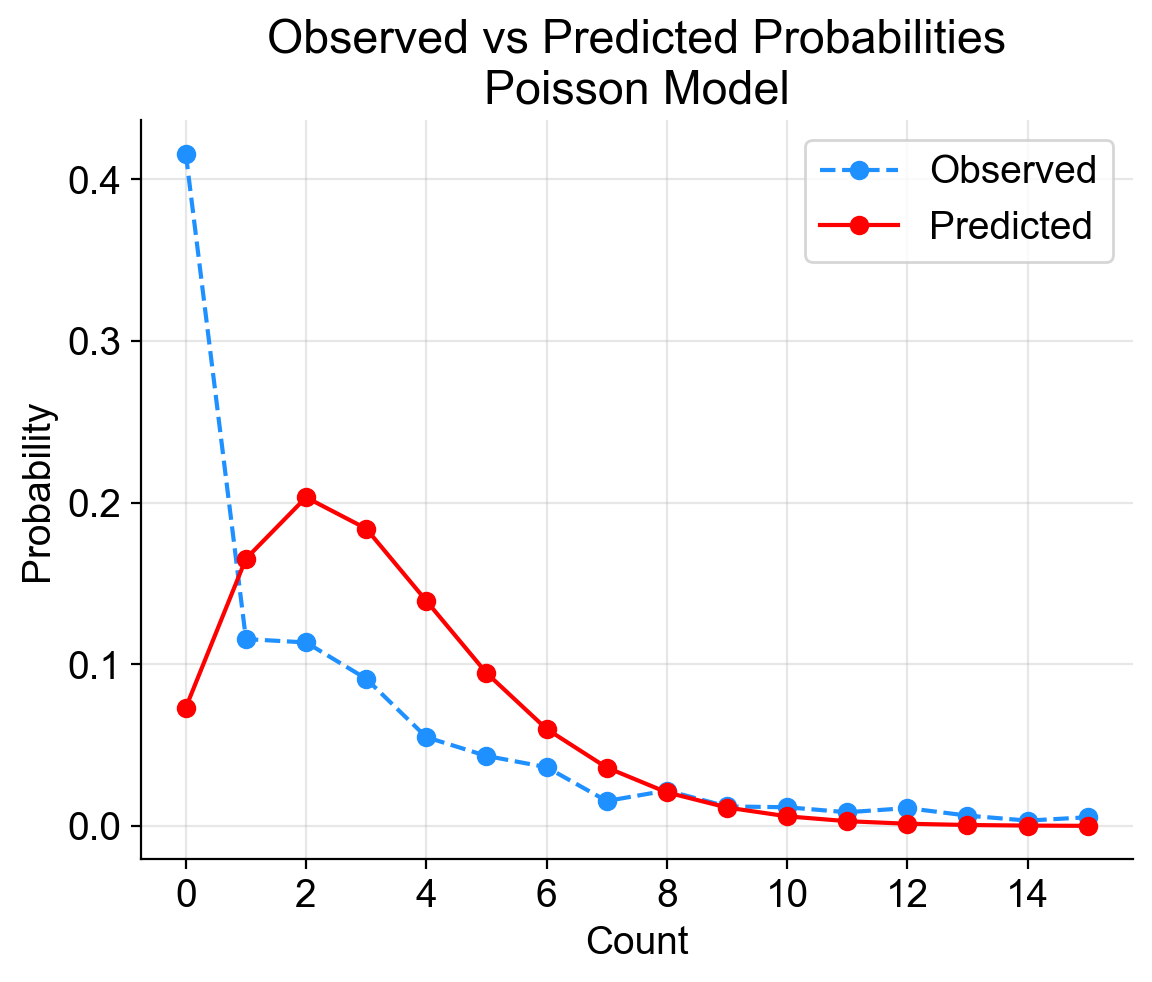

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import poisson, chi2

%config InlineBackend.figure_format = 'retina'

# Load the dataset
dataset = pd.read_csv("datasets/COUNT/rwm1984.csv")

# outwork | .26473 .0934473 2.83 0.005 .0815767 .4478834
# age | .0221169 .002909 7.60 0.000 .0164153 .0278185
# female | .2615599 .0914541 2.86 0.004 .0823132 .4408065
# married | -.128839 .0871441 -1.48 0.139 -.2996382 .0419602
# edlevel2 | -.0743016 .1043152 -0.71 0.476 -.2787557 .1301524
# edlevel3 | -.1825212 .0972583 -1.88 0.061 -.373144 .0081016
# edlevel4 | -.2644094 .1556778 -1.70 0.089 -.5695323 .0407135
# _cons | .0156058 .1801753 0.09 0.931 -.3375313 .3687428

features = ["age", "outwork", "female", "married", "edlevel2", "edlevel3", "edlevel4"]

X = dataset[features]
X = sm.add_constant(X)
y = dataset["docvis"].values

# Fit a Poisson regression model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Display the summary
print(poisson_model.summary())

# Calculate the Poisson probabilities
mu = poisson_model.predict(X)
poisson_probs = poisson.pmf(y, mu)

# Compute the log-likelihood
log_likelihood = np.sum(np.log(poisson_probs))

print(f"Log-likelihood of the data: {log_likelihood}")

# Select a common range for bins
bins_min = min(y.min(), mu.min())
bins_max = max(y.max(), mu.max())

# Create bins for the histogram
bins = np.arange(bins_min, bins_max + 1)

# Plot predicted vs. observed values in a histogram using PMF
sns.histplot(
    y, color="dodgerblue", label="Observed", fill=False, bins=bins, linewidth=1.5
)
sns.histplot(mu, color="red", label="Predicted", fill=False, bins=bins, linewidth=1.5)

plt.xlim(0, 15)

# Use log likelihood of the null model
null_model = poisson(y.mean())
null_log_likelihood = np.sum(np.log(null_model.pmf(y)))

# Perform Chi-Square Test on the log-likelihood
chi2_stat = -2 * (null_log_likelihood - log_likelihood)
p_value = 1 - chi2.cdf(chi2_stat, 1)

print(f"Chi-Square Statistic: {chi2_stat}, p-value: {p_value}")

fig, ax = plt.subplots()
plot_observed_vs_predicted(
    y,
    mu,
    max_count=15,
    alpha=0.0,
    title="Observed vs Predicted Probabilities",
    model_name="Poisson Model",
    ax=ax,
)

### Negative binomial model

/Users/deburky/Library/Caches/pypoetry/virtualenvs/python-ml-projects-QQGQytla-py3.10/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3874
Model:                            GLM   Df Residuals:                     3866
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8653.4
Date:                Thu, 01 May 2025   Deviance:                       6453.2
Time:                        14:56:37   Pearson chi2:                 1.06e+04
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1156
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0091      0.087     -0.104      0.9

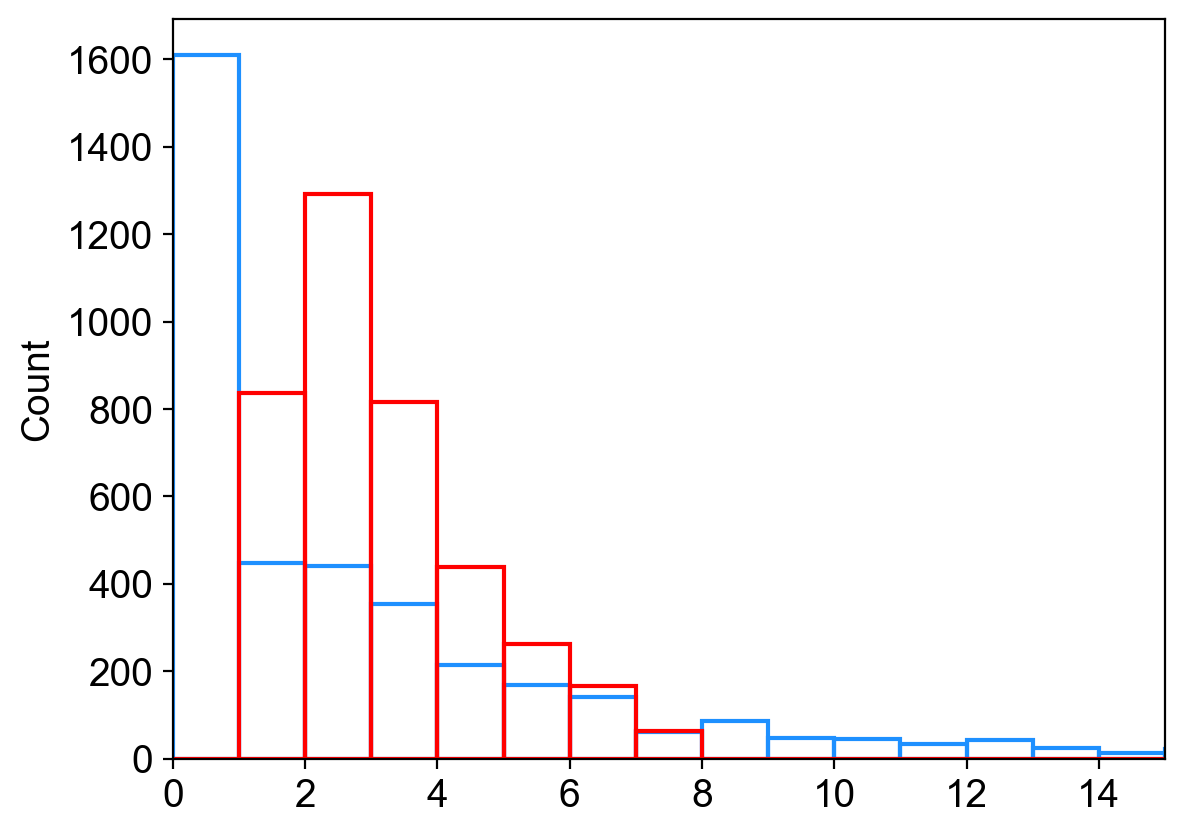

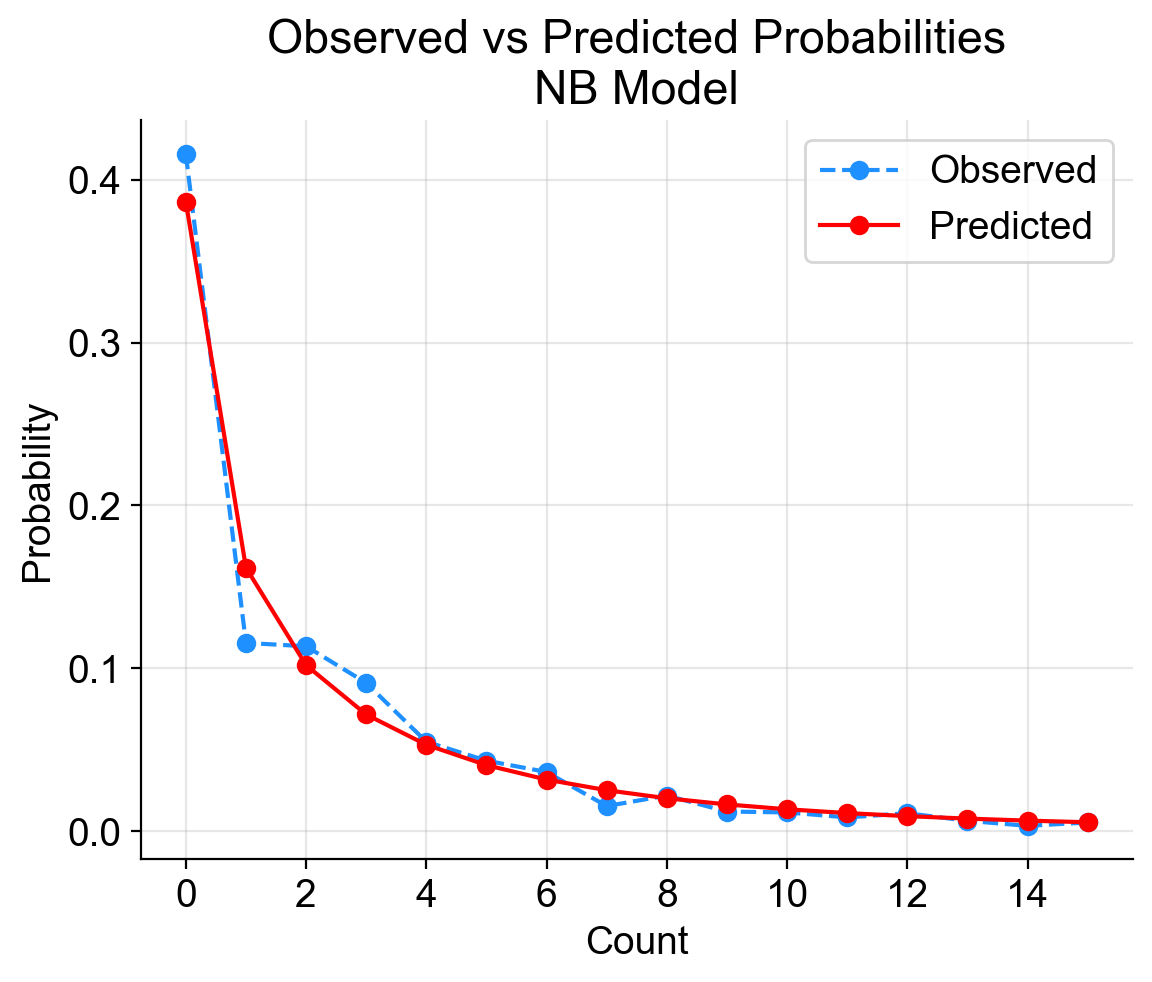

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import poisson, chi2

%config InlineBackend.figure_format = 'retina'

# Load the dataset
dataset = pd.read_csv("datasets/COUNT/rwm1984.csv")

# outwork | .2733504 .0812069 3.37 0.001 .1141879 .4325129
# age | .0232448 .0026847 8.66 0.000 .0179828 .0285068
# female | .3164156 .0758391 4.17 0.000 .1677737 .4650576
# married | -.1906226 .0855496 -2.23 0.026 -.3582968 -.0229485
# edlevel2 | -.1139377 .1051687 -1.08 0.279 -.3200647 .0921893
# edlevel3 | -.1948105 .098729 -1.97 0.048 -.3883158 -.0013051
# edlevel4 | -.3628498 .1321642 -2.75 0.006 -.6218868 -.1038127
# _cons | -.013249 .1520918 -0.09 0.931 -.3113435 .2848456

features = ["age", "outwork", "female", "married", "edlevel2", "edlevel3", "edlevel4"]

X = dataset[features]
X = sm.add_constant(X)
y = dataset["docvis"].values

# Fit a Poisson regression model
poisson_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

# Display the summary
print(poisson_model.summary())

# Calculate the Poisson probabilities
mu = poisson_model.predict(X)
poisson_probs = poisson.pmf(y, mu)

# Compute the log-likelihood
log_likelihood = np.sum(np.log(poisson_probs))

print(f"Log-likelihood of the data: {log_likelihood}")

# Select a common range for bins
bins_min = min(y.min(), mu.min())
bins_max = max(y.max(), mu.max())

# Create bins for the histogram
bins = np.arange(bins_min, bins_max + 1)

# Plot predicted vs. observed values in a histogram using PMF
sns.histplot(
    y, color="dodgerblue", label="Observed", fill=False, bins=bins, linewidth=1.5
)
sns.histplot(mu, color="red", label="Predicted", fill=False, bins=bins, linewidth=1.5)

plt.xlim(0, 15)

# Use log likelihood of the null model
null_model = poisson(y.mean())
null_log_likelihood = np.sum(np.log(null_model.pmf(y)))

# Perform Chi-Square Test on the log-likelihood
chi2_stat = -2 * (null_log_likelihood - log_likelihood)
p_value = 1 - chi2.cdf(chi2_stat, 1)

print(f"Chi-Square Statistic: {chi2_stat}, p-value: {p_value}")

fig, ax = plt.subplots()
plot_observed_vs_predicted(
    y,
    mu,
    max_count=15,
    alpha=2.0,
    title="Observed vs Predicted Probabilities",
    model_name="NB Model",
    ax=ax,
)

### Gradient-boosted decision trees

XGBoost Log-likelihood of the data: -4466.90
CatBoost Log-likelihood of the data: -6355.95


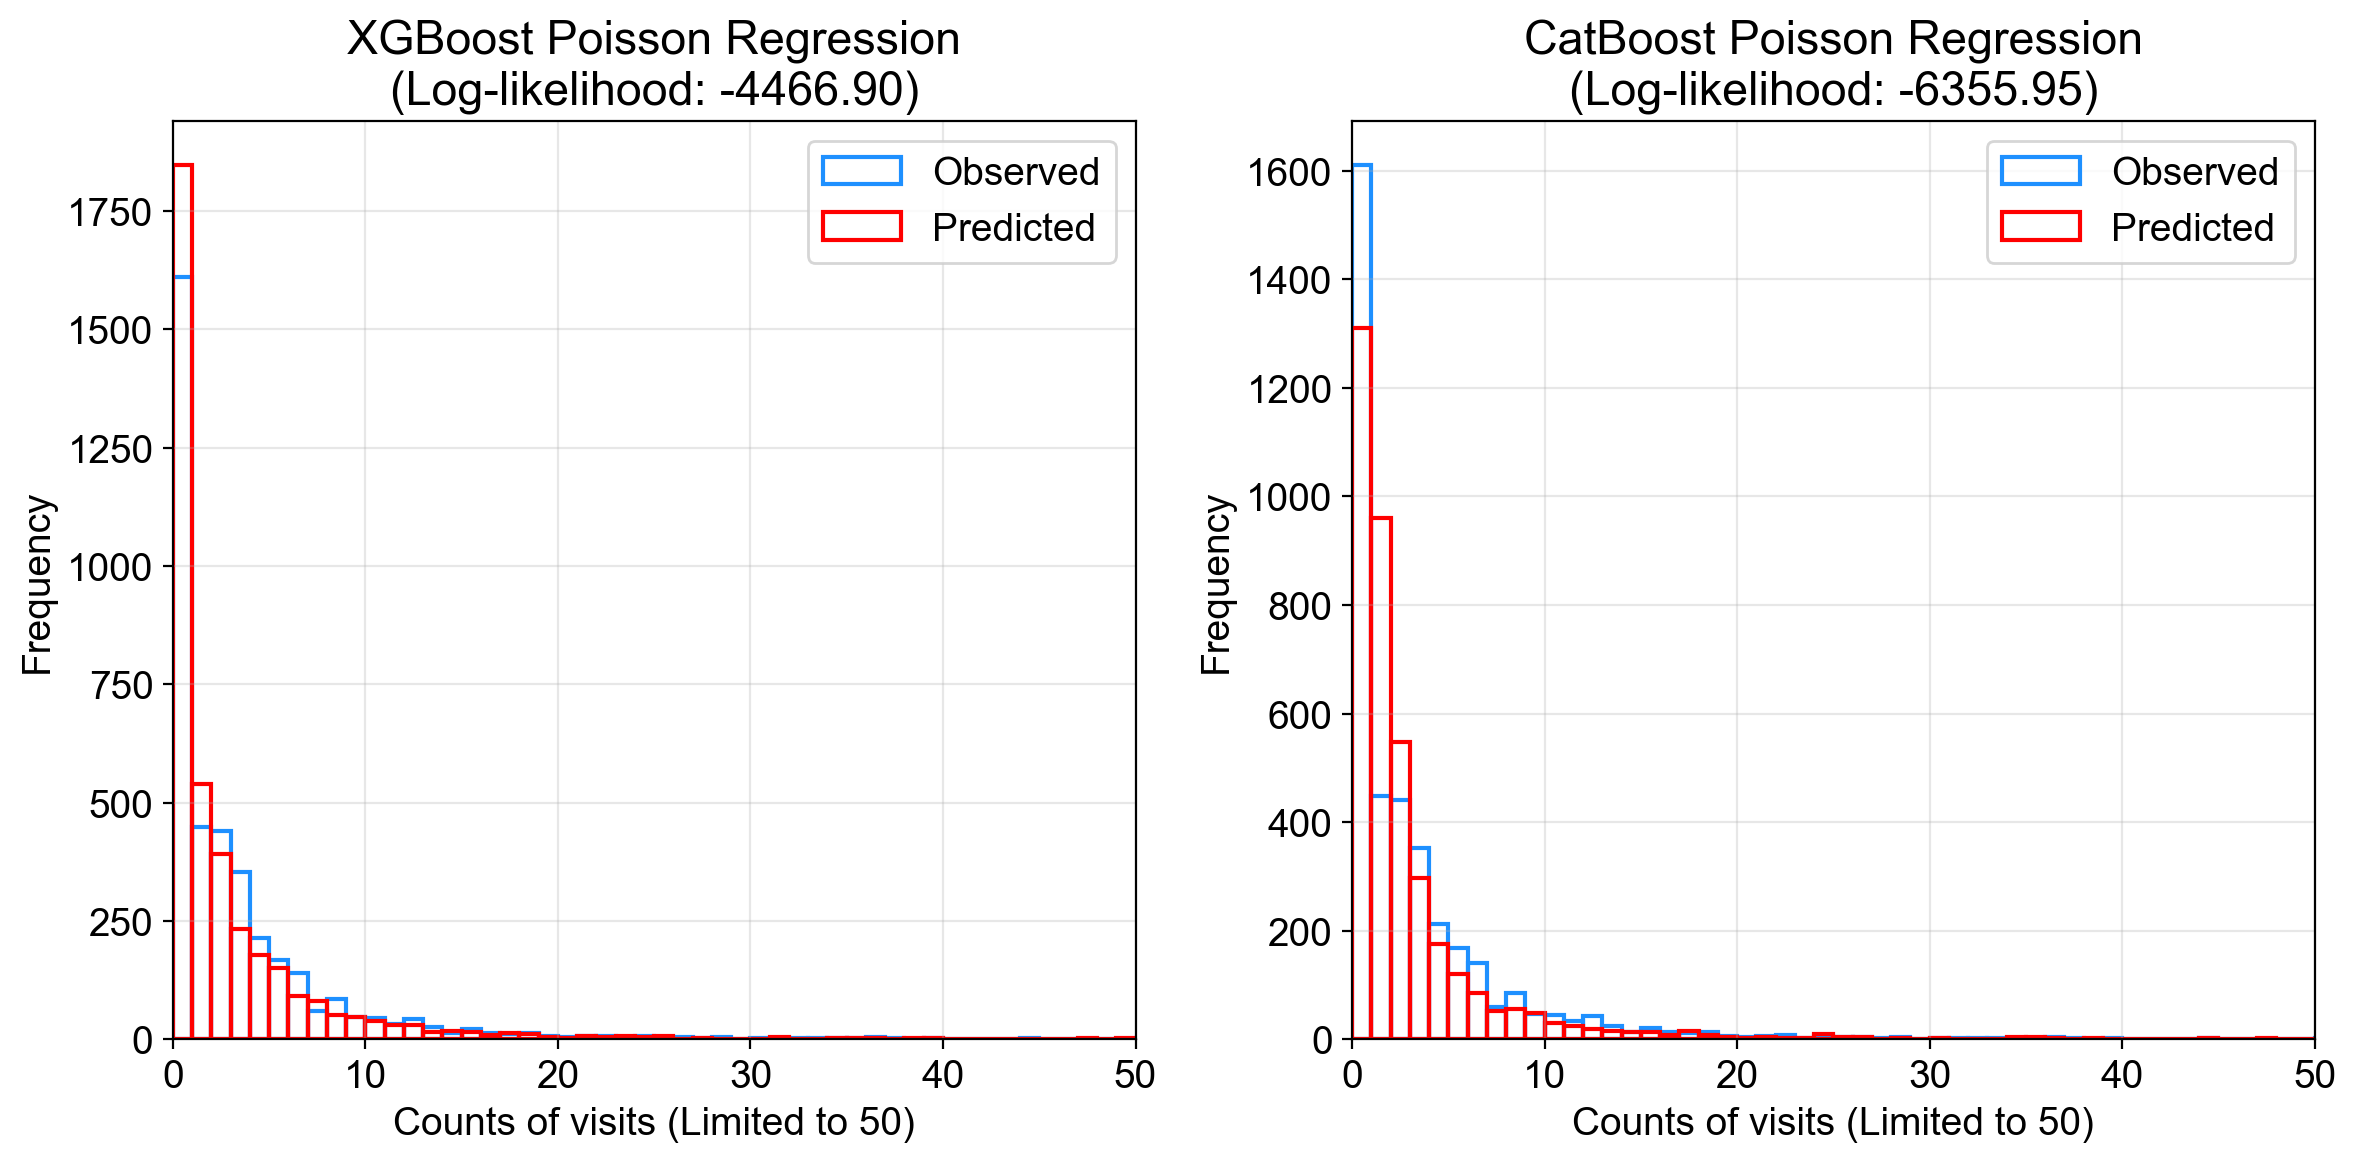

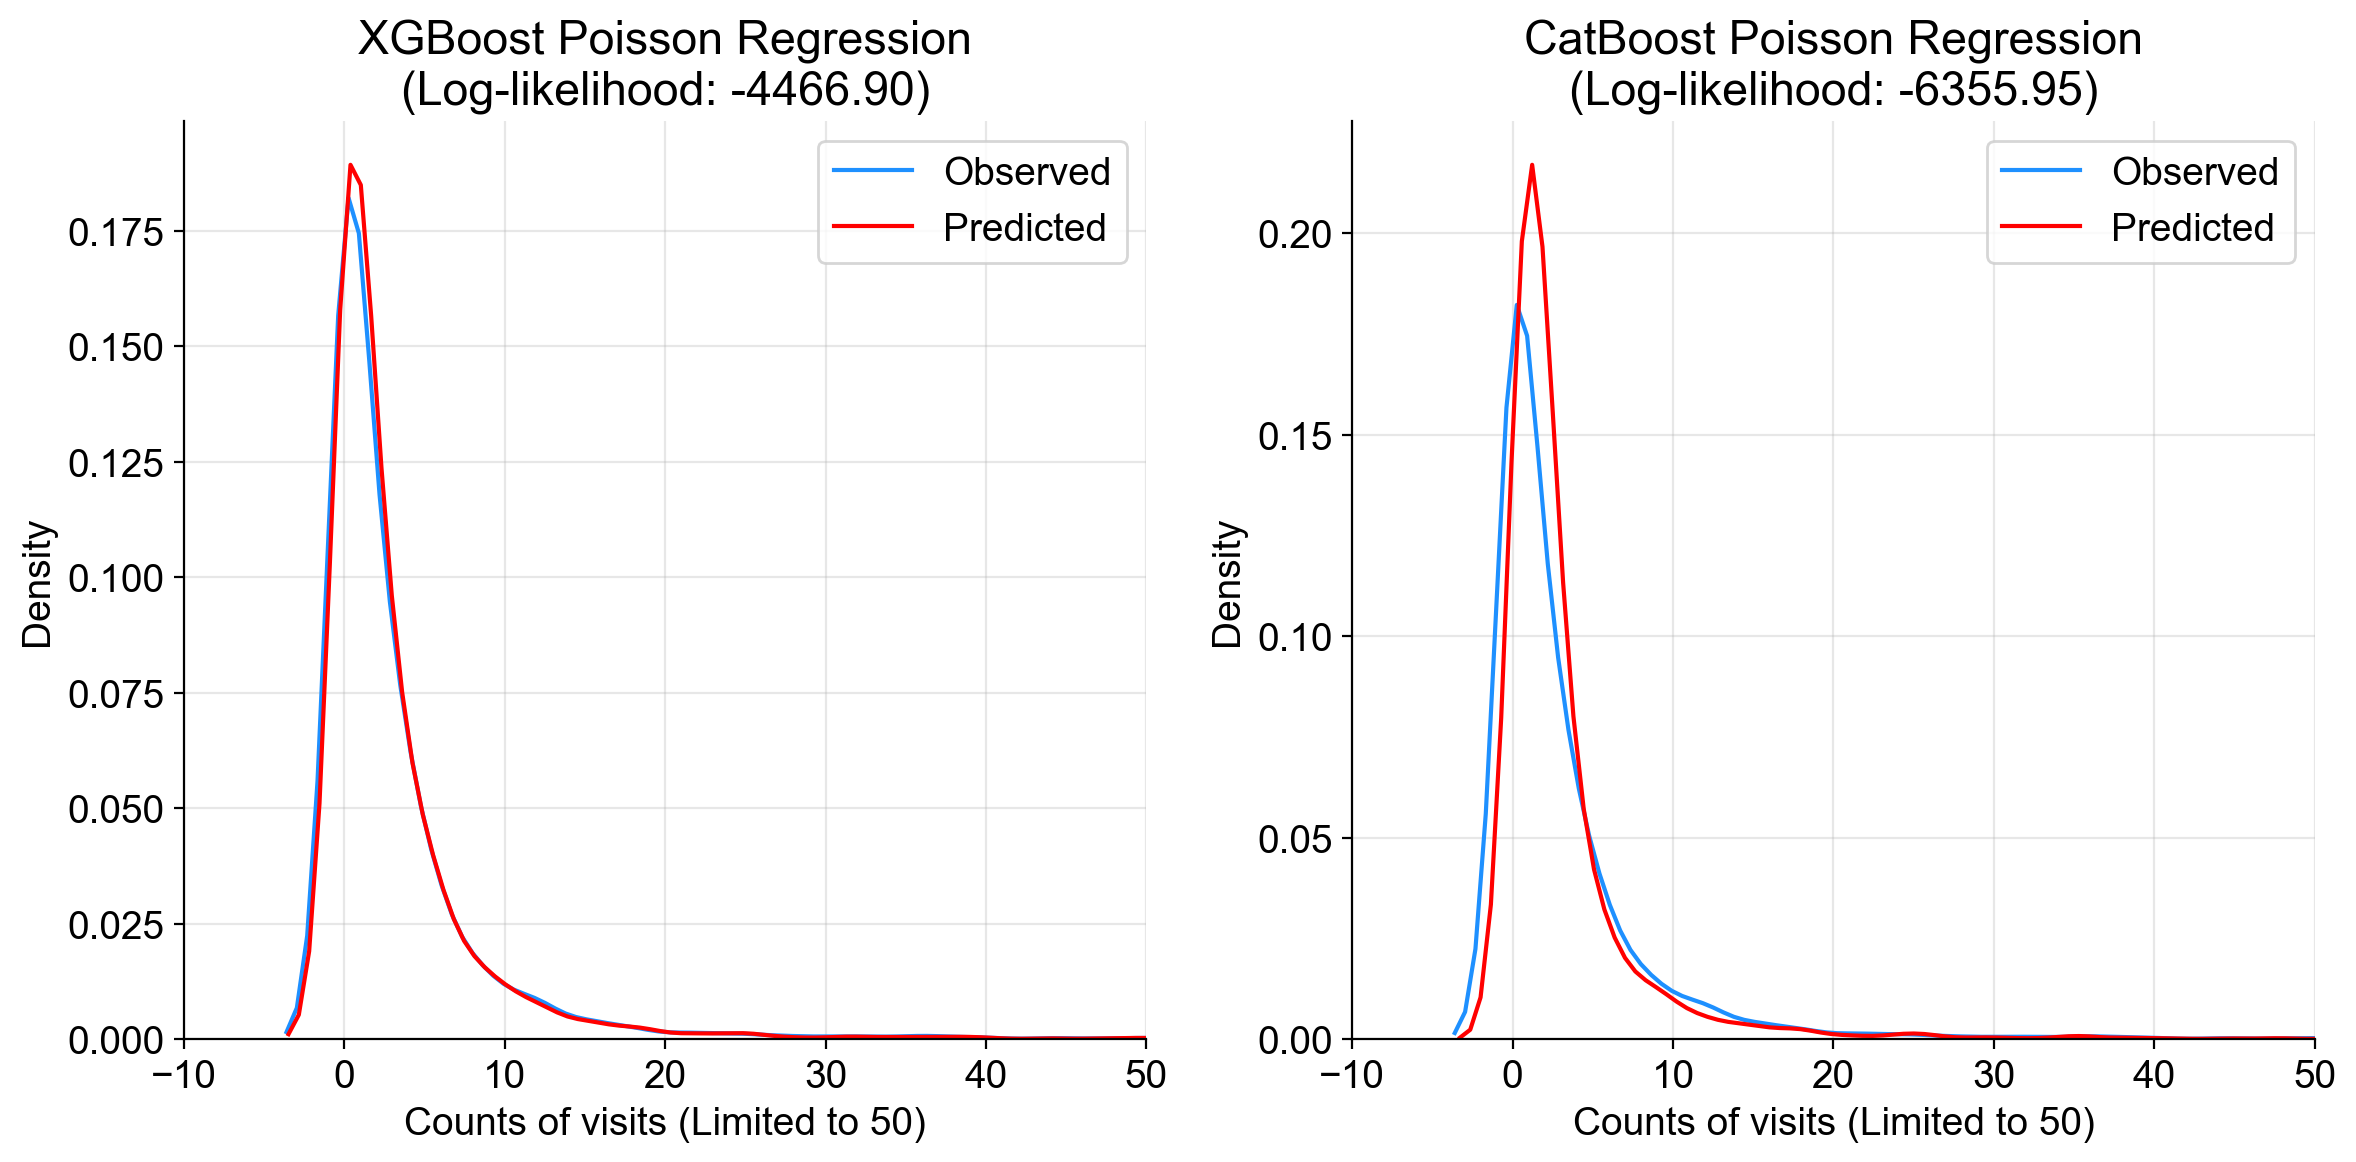

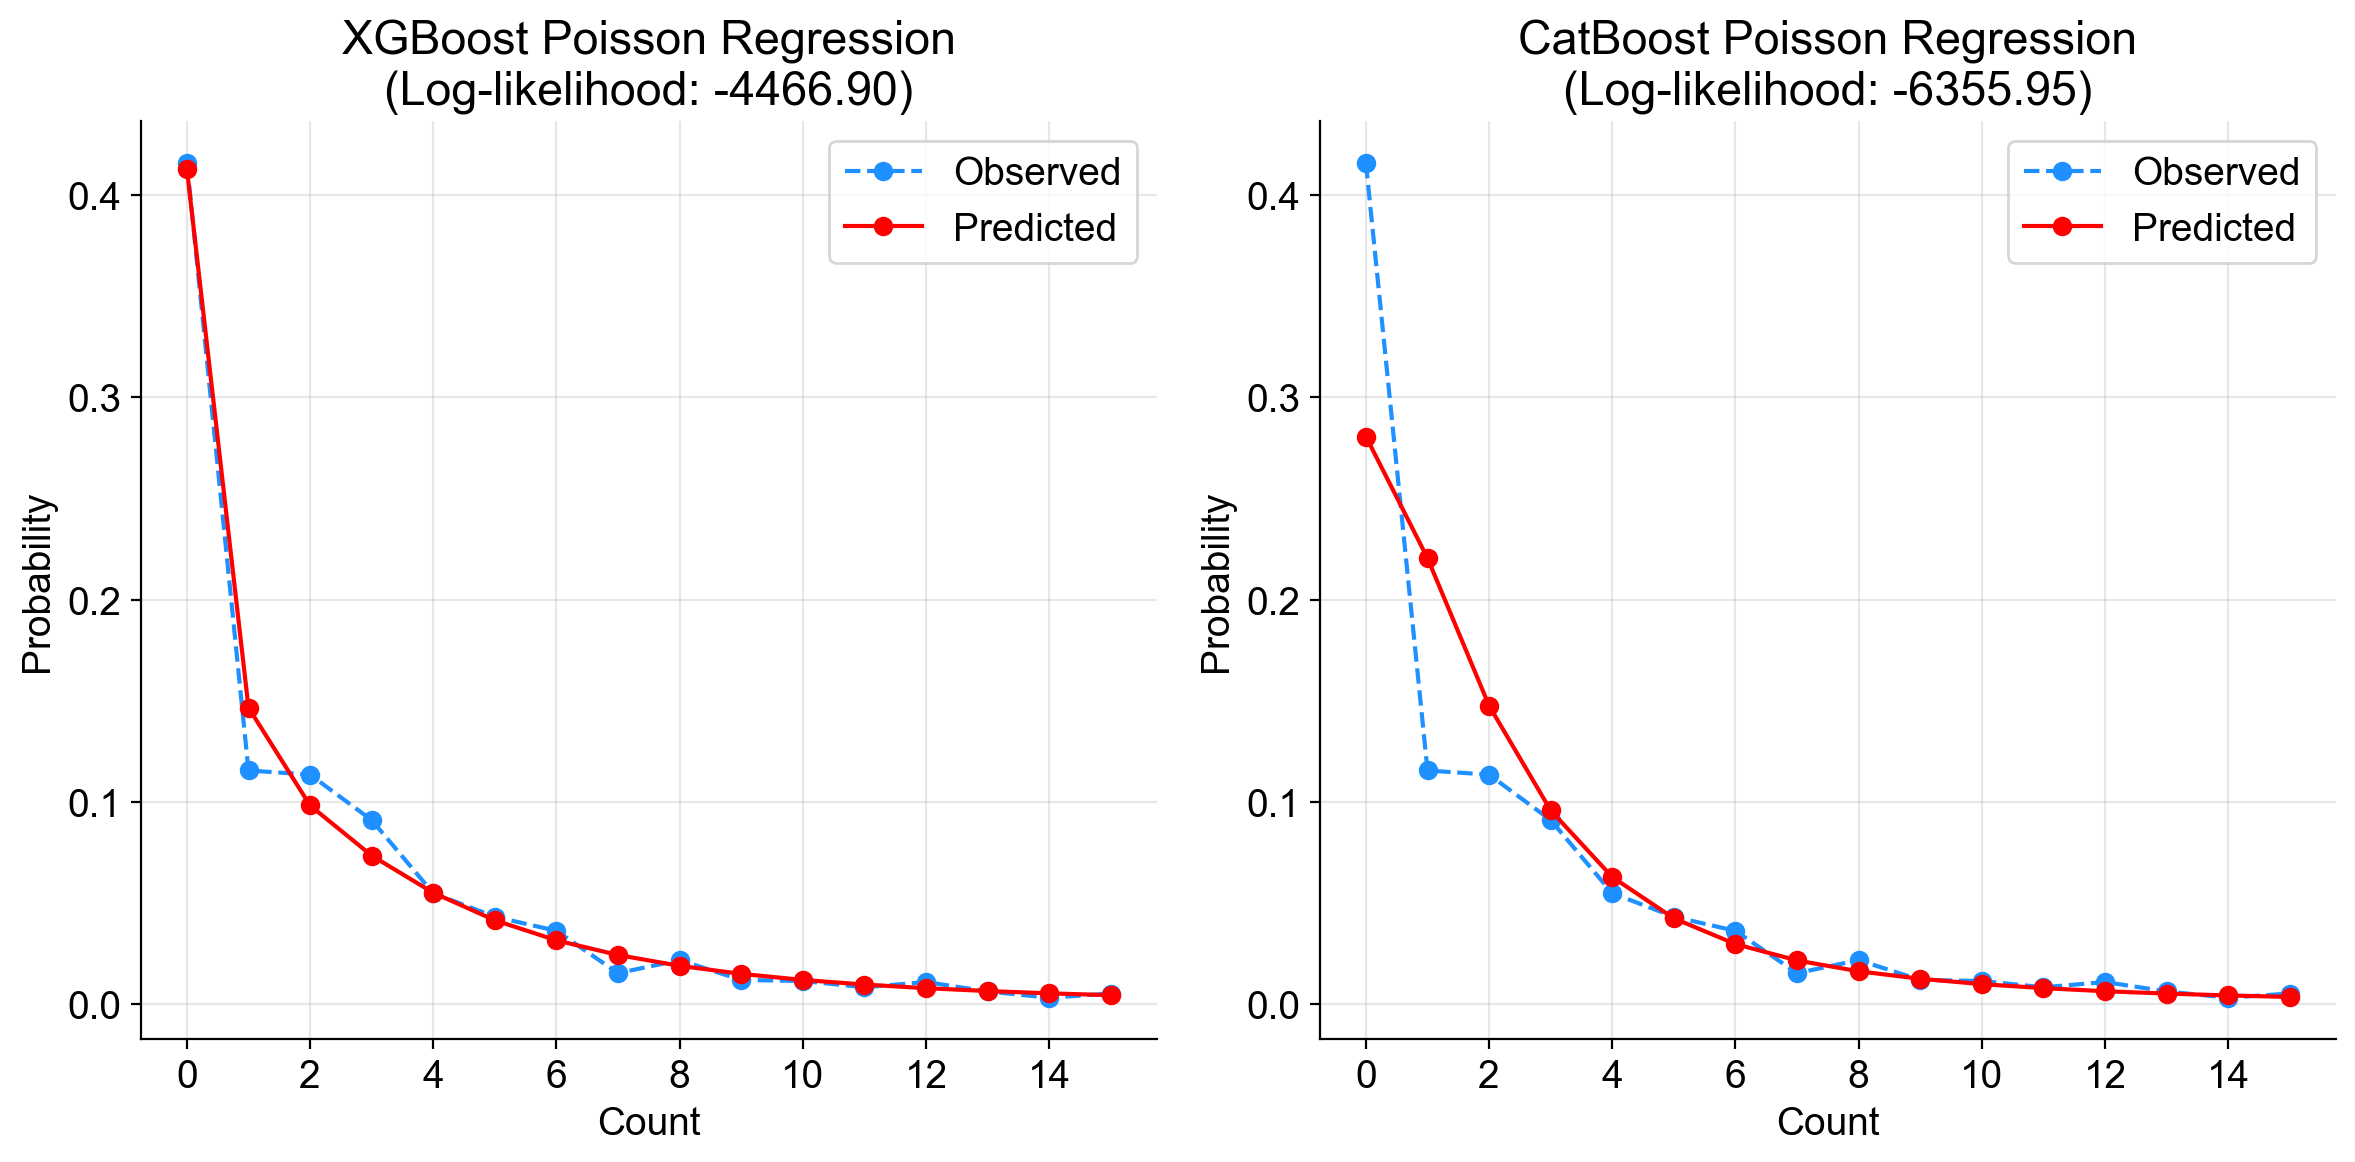

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# Import models
import xgboost as xgb
from catboost import CatBoostRegressor

# Set font to Arial
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({"font.size": 14})

X = pd.concat([cat_frame, num_frame], axis=1)
y = dataset["docvis"].values

# Define models in a dictionary
models = {
    "XGBoost": xgb.XGBRegressor(
        objective="count:poisson", n_estimators=100, max_depth=10, learning_rate=1.0
    ),
    "CatBoost": CatBoostRegressor(
        loss_function="Poisson",
        n_estimators=100,
        max_depth=10,
        learning_rate=1.0,
        verbose=0,
        allow_writing_files=False,
    ),
}

# Fit models and collect results
results = {}
for name, model in models.items():
    model.fit(X, y)
    predictions = model.predict(X)

    # Calculate log-likelihood
    poisson_probs = poisson.pmf(y, predictions)
    log_likelihood = np.sum(np.log(poisson_probs))

    results[name] = {
        "model": model,
        "predictions": predictions,
        "log_likelihood": log_likelihood,
    }

# Print Log-Likelihoods
for name, result in results.items():
    print(f"{name} Log-likelihood of the data: {result['log_likelihood']:.2f}")

# Select a common range for bins
bins_min = min(y.min(), min(result["predictions"].min() for result in results.values()))
bins_max = max(y.max(), max(result["predictions"].max() for result in results.values()))
bins = np.arange(bins_min, bins_max + 1)

# Plotting Observed vs Predicted Histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

for ax, (name, result) in zip(axes, results.items()):
    sns.histplot(
        y,
        color="dodgerblue",
        label="Observed",
        fill=False,
        bins=bins,
        linewidth=1.5,
        ax=ax,
    )
    sns.histplot(
        result["predictions"],
        color="red",
        label="Predicted",
        fill=False,
        bins=bins,
        linewidth=1.5,
        ax=ax,
        alpha=1.0,
    )
    ax.set_xlabel("Counts of visits (Limited to 50)")
    ax.set_ylabel("Frequency")
    ax.set_title(
        f"{name} Poisson Regression\n(Log-likelihood: {result['log_likelihood']:.2f})"
    )
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 50)

plt.tight_layout()
plt.show()

# Plotting Observed vs Predicted Densities
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

for ax, (name, result) in zip(axes, results.items()):
    sns.kdeplot(
        y, color="dodgerblue", label="Observed", fill=False, linewidth=1.5, ax=ax
    )
    sns.kdeplot(
        result["predictions"],
        color="red",
        label="Predicted",
        fill=False,
        linewidth=1.5,
        ax=ax,
    )
    ax.set_xlabel("Counts of visits (Limited to 50)")
    ax.set_ylabel("Density")
    ax.set_title(
        f"{name} Poisson Regression\n(Log-likelihood: {result['log_likelihood']:.2f})"
    )
    ax.legend()
    ax.grid(True, alpha=0.3)
    # Disable spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlim(-10, 50)

plt.tight_layout()
plt.show()

# add visualization for mu_xgb and mu_cb with plot_observed_vs_predicted
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

for i, (name, result) in enumerate(results.items(), 1):
    mu = result["predictions"]
    plot_observed_vs_predicted(
        y,
        mu,
        max_count=15,
        alpha=None,
        title=f"{name} Poisson Regression",
        model_name=f"(Log-likelihood: {result['log_likelihood']:.2f})",
        ax=axes[i - 1],
    )
plt.tight_layout()

## Poisson regression with 🐍 Python

Converged in 12 iterations.


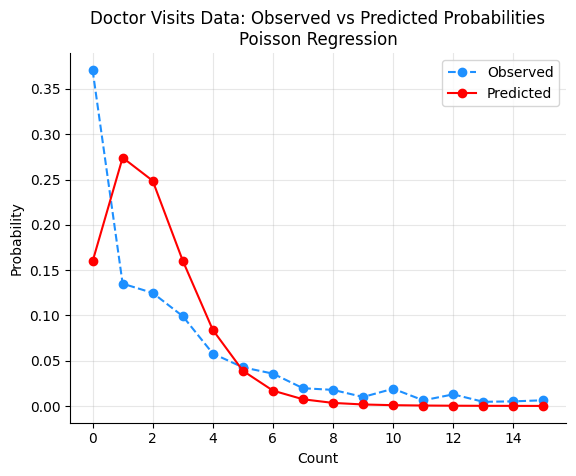

In [ ]:
import pandas as pd
from fisher_poisson_regression import FisherPoissonRegression
from utils import plot_observed_vs_predicted

# path_to_csv = (
#     "https://raw.githubusercontent.com/"
#     "vincentarelbundock/Rdatasets/refs/heads/master/csv/COUNT/rwm.csv"
# )

path_to_csv = "Rdatasets/csv/COUNT/rwm.csv"
docvis_data = pd.read_csv(path_to_csv)

poisson_model = FisherPoissonRegression(use_bias=False)

X = docvis_data[["hhninc"]].values
y = docvis_data["docvis"].values

# Fit the Poisson regression model
poisson_model.fit(X, y)

# Make predictions
mu = poisson_model.predict(X)

# Plot Observed vs Predicted probabilities
df_results = plot_observed_vs_predicted(
    y,
    mu,
    max_count=15,
    title="Doctor Visits Data: Observed vs Predicted Probabilities",
    model_name="Poisson Regression",
)

In [28]:
print(f"Negative binomial coefficient: {poisson_model.weights[0]:.4f}")

poisson_model_sm = sm.GLM(y, X, family=sm.families.Poisson()).fit()

print(poisson_model_sm.summary())

Negative binomial coefficient: 0.1853
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                27326
Model:                            GLM   Df Residuals:                    27325
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2646e+05
Date:                Thu, 01 May 2025   Deviance:                   1.9987e+05
Time:                        15:12:50   Pearson chi2:                 5.69e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             -2.678
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            

Converged in 8 iterations.


,Count,Frequency Observed,Frequency Predicted,Probability Observed,Probability Predicted
0,0,10135,12057.5746,0.3709,0.4412
1,1,3692,4136.7049,0.1351,0.1514
2,2,3412,2490.5743,0.1249,0.0911
3,3,2711,1718.4623,0.0992,0.0629
4,4,1584,1263.2920,0.0580,0.0462
5,5,1169,964.0854,0.0428,0.0353
6,6,979,754.5029,0.0358,0.0276
7,7,539,601.4624,0.0197,0.0220
8,8,489,486.3702,0.0179,0.0178
9,9,275,397.8868,0.0101,0.0146


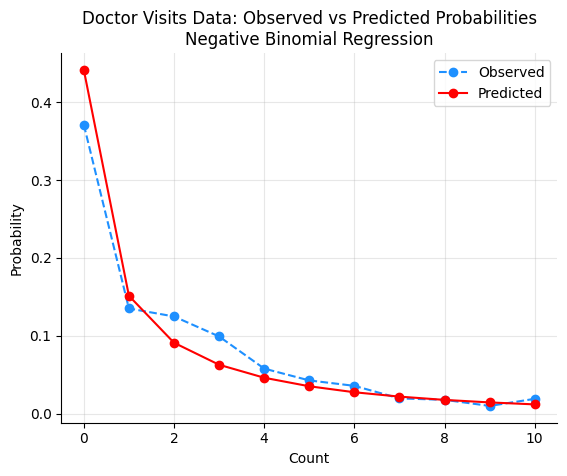

In [ ]:
from fisher_poisson_regression import FisherNegativeBinomialRegression

neg_model = FisherNegativeBinomialRegression(alpha=2.0)

X = docvis_data[["hhninc"]].values
y = docvis_data["docvis"].values

neg_model.fit(X, y)

mu = neg_model.predict(X)
# mle = np.full_like(y, np.mean(y))

# Plot Observed vs Predicted probabilities
df_results = plot_observed_vs_predicted(
    y,
    mu,
    max_count=10,
    title="Doctor Visits Data: Observed vs Predicted Probabilities",
    model_name="Negative Binomial Regression",
    alpha=2.5,
)

# Set pandas display options to :.4f
pd.set_option("display.float_format", "{:.4f}".format)
df_results

In [ ]:
print(f"Negative binomial coefficient: {neg_model.weights[0]:.4f}")

import statsmodels.api as sm

nb_model_sm = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=2.0))

print(nb_model_sm.fit().summary())

Negative binomial coefficient: 0.2896
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                27326
Model:                            GLM   Df Residuals:                    27325
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63102.
Date:                Thu, 01 May 2025   Deviance:                       33465.
Time:                        15:11:10   Pearson chi2:                 8.61e+04
No. Iterations:                    10   Pseudo R-squ. (CS):            -0.1802
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            

In [ ]:
import numpy as np

preds_ps = np.exp(X @ poisson_model.weights)
preds_nb = np.exp(X @ neg_model.weights)

pd.DataFrame(
    {
        "Observed": y,
        "Poisson": preds_ps,
        "Negative Binomial": preds_nb,
    }
).describe()

,Observed,Poisson,Negative Binomial
count,27326.0000,27326.0000,27326.0000
mean,3.1835,2.1043,4.5982
std,5.6897,3.7973,81.7301
min,0.0000,1.0000,1.0000
25%,0.0000,1.5600,2.0038
50%,1.0000,1.8093,2.5263
75%,4.0000,2.2184,3.4740
max,121.0000,293.9063,7205.1802
